<a href="https://colab.research.google.com/github/fatimamds/dietlane_app_volume/blob/main/server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up environment

In [ ]:
# Installing mmseg (or Clone mmseg repo & setup) 
!rm -rf mmsegmentation
!git clone https://github.com/LARC-CMU-SMU/FoodSeg103-Benchmark-v1.git  
%cd FoodSeg103-Benchmark-v1                                                 
!pip install -e .
!pip install -r requirements/optional.txt

# Install PyTorch
!pip install -U torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV (+ addict & yapf)
!pip install mmcv-full==1.3.0+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html 
# Installing timm
!pip install timm

# Clone Volume Estimation Repo  #%cd ..
!git clone https://github.com/fatimamds/dietlane_app_volume
!mkdir input/
!mkdir output/
# Install labelme
!pip install labelme

# Install Flask & Pyngrok for API, and CORS to solve fetch error
!pip install flask-ngrok
!pip install -U flask-cors

Cloning into 'FoodSeg103-Benchmark-v1'...
remote: Enumerating objects: 775, done.
remote: Counting objects: 100% (775/775), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 775 (delta 421), reused 728 (delta 394), pack-reused 0
Receiving objects: 100% (775/775), 3.63 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (421/421), done.
/content/FoodSeg103-Benchmark-v1
Obtaining file:///content/FoodSeg103-Benchmark-v1
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=eef8cb1e4e7dd2a3cfebbfa68099c43c7d734d73c7991a7c460702d8087c9821
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
  Running setup.py develop for mmsegmentation
     |████████████████████████████████| 481kB 7.8MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 92kB 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 25kB/s 
     |████████████████████████████████| 6.6MB 23.8MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
Looking in links: https://download.openmmlab.com/mmcv/dist/index.html
     |████████████████████████████████| 24.4MB 130kB/s 
     |████████████████████████████████| 194kB 9.2MB/s 
     |████████████████████████████████| 378kB 9.1MB/s 
Cloning into 'dietlane_app_volume'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (92/92), done.
remote: 

###### Checking Environment Installation & Importing Modules

In [ ]:
# Check nvcc version - NVIDIA CUDA Compiler
!nvcc -V
# Check GCC version
!gcc --version

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from dietlane_app_volume.palette import palette
print(mmseg.__version__)

# Import other required Modules
import os                               # execfile('file.py')  # os.system('python file.py')
import json
import cv2
import matplotlib.pyplot as plt

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.5.0+cu101 True
0.11.0


# Fetching trained networks

In [ ]:
!rm -r pretrained_model

# Download our trained SEGMENTATION model (Encoder: ReLeM-R-50 |	Decoder: CCNet)
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18XQnJFoxLF_2wFtFmcbQktJReOm-o64X' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18XQnJFoxLF_2wFtFmcbQktJReOm-o64X" -O iter_80000.pth && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16bM9qJnAfDd_mELOZKjLvnI_taZYWqaH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16bM9qJnAfDd_mELOZKjLvnI_taZYWqaH" -O ccnet_r50-d8_512x1024_80k.py && rm -rf /tmp/cookies.txt

# Download our trained DEPTH model (Senet)
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QaUkdOiGpMuzMeWCGbey0sT0wXY0xtsj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1QaUkdOiGpMuzMeWCGbey0sT0wXY0xtsj" -O pretrained_model.zip && rm -rf /tmp/cookies.txt
!unzip pretrained_model.zip  #unzipping
!rm -r pretrained_model.zip  #removing zipped file to free space

--2021-07-15 02:41:20--  https://docs.google.com/uc?export=download&confirm=&id=18XQnJFoxLF_2wFtFmcbQktJReOm-o64X
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.102, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘iter_80000.pth’

iter_80000.pth          [ <=>                ]   3.21K  --.-KB/s    in 0s      

2021-07-15 02:41:21 (51.4 MB/s) - ‘iter_80000.pth’ saved [3284]

--2021-07-15 02:41:21--  https://docs.google.com/uc?export=download&confirm=X27Y&id=16bM9qJnAfDd_mELOZKjLvnI_taZYWqaH
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.139, 74.125.142.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/3mkqrfibm5382v4ho99c1

###### Building our Food Segmentation Model

In [ ]:
# build the model from a config file and a checkpoint file
config_file = './ccnet_r50-d8_512x1024_80k.py' 
checkpoint_file = './iter_80000.pth'
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


# Defining functions for Backend Execution

In [ ]:
def predict_mask():
  # test a single image
  img = 'input/test.png'
  if cv2.imread(img).shape[2]==4:
      img = img[:,:,:3]
      cv2.imwrite('input/test.png', img)
  result = inference_segmentor(model, img)
  # save the visualization results to image files
  model.show_result(img, result,  palette=palette, out_file='demo/result.png')

# !python "dietlane_app_volume/masktojson.py"
# !python "dietlane_app_volume/demo.py"
def find_vol():
  os.system('python dietlane_app_volume/masktojson.py')
  os.system('python dietlane_app_volume/demo.py')
  with open('output/volume.json') as json_file:
    data = json.load(json_file)  # returns JSON object as a python dictionary/list
  return data

def clear_input():
  os.remove("input/test.png")

def display_out():
  with open('output/volume.json') as json_file:
    data = json.load(json_file) 
  print(data)
  org = cv2.cvtColor(cv2.imread("input/test.png"), cv2.COLOR_BGR2RGB)
  mask = cv2.cvtColor(cv2.imread("demo/rgb_mask.png"), cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(cv2.imread("output/out_grey.png"), cv2.COLOR_BGR2RGB)
  rgbd = cv2.cvtColor(cv2.imread("output/out_color.png"), cv2.COLOR_BGR2RGB)
  array_img = [org, mask, gray, rgbd]
  for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(array_img[i])
  plt.show()

# Setting up Flask API

In [ ]:
from flask import Flask
from flask import jsonify, make_response, request
from flask_ngrok import run_with_ngrok
from flask_cors import CORS

import numpy as np 
import base64

#os.environ["FLASK_ENV"] = "development"   #import os

# Running the Flask app
app = Flask(__name__)
CORS(app)
run_with_ngrok(app)

# Define Flask routes
@app.route("/", methods=['GET'])
def index():
  return "Hello from Colab!"

@app.route("/trialroute")
def postyy():
  return "Another hi"

@app.route('/uploadimage' , methods=['POST'])
def predict_vol():
  print(request.json)
  img_str = request.json['image']
  org_str = base64.b64decode(img_str)
  npimg = np.fromstring(org_str, np.uint8)
  img = cv2.imdecode(npimg,cv2.IMREAD_COLOR)
  os.path.exists('input/test.png') and clear_input()
  cv2.imwrite('input/test.png', img)
  predict_mask()
  vol_data = find_vol()
  print(vol_data)
  return jsonify({'foodprofile': vol_data})

if __name__ == '__main__':
  app.run()  #app.run(Debug=True)   #if os.environ = development

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://bf796815c895.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [15/Jul/2021 02:48:43] "OPTIONS /uploadimage HTTP/1.1" 200 -
[2021-07-15 02:48:44,299] ERROR in app: Exception on /uploadimage [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask_cors/extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/us

{}


127.0.0.1 - - [15/Jul/2021 02:49:33] "OPTIONS /uploadimage HTTP/1.1" 200 -


{'image': 'iVBORw0KGgoAAAANSUhEUgAAA1wAAAK3CAYAAACREU4xAACAAElEQVR42uydd3xc9ZX2saTRFM2o927JtnpvI82Mpqt32XJvYJsOBpua0CFACJCyoQQIkEBCDyUkBEhISDZlN9l386ZsskAaBAKBlG3vn8/7O+fe3+hqLBmyaS7nj+dzp9wp987I/n3nOec5J/y///f/IBKJRCKRSCQSiUSiv7xOkJMgEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQiAS6RSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBIJcIlEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikUiASyQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEglwiUQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSIBLJBKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEAlwikUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBIdm/qf//mf417yPRCJRCIBLjkRIpFIJBKIEjATiUQikQCXSCQSiQSSRAJwIpFIJMAlEolEIgErkQCYS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
127.0.0.1 - - [15/Jul/2021 02:49:52] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'turkey', 'measure': 186.8597312171587, 'calories': 336, 'proteins': 18.91, 'fats': 28.23, 'carbs': 0, 'fiber': 0}, {'name': 'corn', 'measure': 113.15554294626408, 'calories': 88, 'proteins': 2.23, 'fats': 3.73, 'carbs': 13.93, 'fiber': 1.9}, {'name': 'cucumber', 'measure': 112.94871928409178, 'calories': 15, 'proteins': 0.65, 'fats': 0.11, 'carbs': 3.63, 'fiber': 0.5}]


127.0.0.1 - - [15/Jul/2021 02:52:09] "OPTIONS /uploadimage HTTP/1.1" 200 -


{'image': 'iVBORw0KGgoAAAANSUhEUgAAA1wAAAK3CAYAAACREU4xAACAAElEQVR42uydd3xc9ZX2saTRFM2o927JtnpvI82Mpqt32XJvYJsOBpua0CFACJCyoQQIkEBCDyUkBEhISDZlN9l386ZsskAaBAKBlG3vn8/7O+fe3+hqLBmyaS7nj+dzp9wp987I/n3nOec5J/y///f/IBKJRCKRSCQSiUSiv7xOkJMgEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQiAS6RSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBIJcIlEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikUiASyQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEglwiUQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSIBLJBKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEAlwikUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBIdm/qf//mf417yPRCJRCIBLjkRIpFIJBKIEjATiUQikQCXSCQSiQSSRAJwIpFIJMAlEolEIgErkQCYS

127.0.0.1 - - [15/Jul/2021 02:52:39] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'turkey', 'measure': 186.8597312171587, 'calories': 336, 'proteins': 18.91, 'fats': 28.23, 'carbs': 0, 'fiber': 0}, {'name': 'corn', 'measure': 113.15554294626408, 'calories': 88, 'proteins': 2.23, 'fats': 3.73, 'carbs': 13.93, 'fiber': 1.9}, {'name': 'cucumber', 'measure': 112.94871928409178, 'calories': 15, 'proteins': 0.65, 'fats': 0.11, 'carbs': 3.63, 'fiber': 0.5}]


127.0.0.1 - - [15/Jul/2021 02:53:11] "OPTIONS /uploadimage HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2021 02:53:11] "OPTIONS /uploadimage HTTP/1.1" 200 -
[2021-07-15 02:53:12,806] ERROR in app: Exception on /uploadimage [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask_cors/extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 

{}
{'image': 'iVBORw0KGgoAAAANSUhEUgAAA1wAAAK3CAYAAACREU4xAACAAElEQVR42uydd3xc9ZX2saTRFM2o927JtnpvI82Mpqt32XJvYJsOBpua0CFACJCyoQQIkEBCDyUkBEhISDZlN9l386ZsskAaBAKBlG3vn8/7O+fe3+hqLBmyaS7nj+dzp9wp987I/n3nOec5J/y///f/IBKJRCKRSCQSiUSiv7xOkJMgEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQiAS6RSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBIJcIlEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikUiASyQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEglwiUQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSIBLJBKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEAlwikUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBIdm/qf//mf417yPRCJRCIBLjkRIpFIJBKIEjATiUQikQCXSCQSiQSSRAJwIpFIJMAlEolEIgErkQ

127.0.0.1 - - [15/Jul/2021 02:53:20] "OPTIONS /uploadimage HTTP/1.1" 200 -


{'image': 'iVBORw0KGgoAAAANSUhEUgAAA1wAAAK3CAYAAACREU4xAACAAElEQVR42uydd3xc9ZX2saTRFM2o927JtnpvI82Mpqt32XJvYJsOBpua0CFACJCyoQQIkEBCDyUkBEhISDZlN9l386ZsskAaBAKBlG3vn8/7O+fe3+hqLBmyaS7nj+dzp9wp987I/n3nOec5J/y///f/IBKJRCKRSCQSiUSiv7xOkJMgEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQiAS6RSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBIJcIlEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikUiASyQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEglwiUQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSIBLJBKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEAlwikUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBIdm/qf//mf417yPRCJRCIBLjkRIpFIJBKIEjATiUQikQCXSCQSiQSSRAJwIpFIJMAlEolEIgErkQCYS

127.0.0.1 - - [15/Jul/2021 02:53:31] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'turkey', 'measure': 186.8597312171587, 'calories': 336, 'proteins': 18.91, 'fats': 28.23, 'carbs': 0, 'fiber': 0}, {'name': 'corn', 'measure': 113.15554294626408, 'calories': 88, 'proteins': 2.23, 'fats': 3.73, 'carbs': 13.93, 'fiber': 1.9}, {'name': 'cucumber', 'measure': 112.94871928409178, 'calories': 15, 'proteins': 0.65, 'fats': 0.11, 'carbs': 3.63, 'fiber': 0.5}]


127.0.0.1 - - [15/Jul/2021 02:53:39] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'turkey', 'measure': 186.8597312171587, 'calories': 336, 'proteins': 18.91, 'fats': 28.23, 'carbs': 0, 'fiber': 0}, {'name': 'corn', 'measure': 113.15554294626408, 'calories': 88, 'proteins': 2.23, 'fats': 3.73, 'carbs': 13.93, 'fiber': 1.9}, {'name': 'cucumber', 'measure': 112.94871928409178, 'calories': 15, 'proteins': 0.65, 'fats': 0.11, 'carbs': 3.63, 'fiber': 0.5}]


127.0.0.1 - - [15/Jul/2021 02:55:18] "OPTIONS /uploadimage HTTP/1.1" 200 -
[2021-07-15 02:55:19,219] ERROR in app: Exception on /uploadimage [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask_cors/extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/us

{}
{'image': 'iVBORw0KGgoAAAANSUhEUgAAA1wAAAK3CAYAAACREU4xAACAAElEQVR42uydd3xc9ZX2saTRFM2o927JtnpvI82Mpqt32XJvYJsOBpua0CFACJCyoQQIkEBCDyUkBEhISDZlN9l386ZsskAaBAKBlG3vn8/7O+fe3+hqLBmyaS7nj+dzp9wp987I/n3nOec5J/y///f/IBKJRCKRSCQSiUSiv7xOkJMgEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQiAS6RSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBIJcIlEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikUiASyQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEglwiUQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSIBLJBKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEAlwikUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBIdm/qf//mf417yPRCJRCIBLjkRIpFIJBKIEjATiUQikQCXSCQSiQSSRAJwIpFIJMAlEolEIgErkQ

127.0.0.1 - - [15/Jul/2021 02:55:38] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'turkey', 'measure': 186.8597312171587, 'calories': 336, 'proteins': 18.91, 'fats': 28.23, 'carbs': 0, 'fiber': 0}, {'name': 'corn', 'measure': 113.15554294626408, 'calories': 88, 'proteins': 2.23, 'fats': 3.73, 'carbs': 13.93, 'fiber': 1.9}, {'name': 'cucumber', 'measure': 112.94871928409178, 'calories': 15, 'proteins': 0.65, 'fats': 0.11, 'carbs': 3.63, 'fiber': 0.5}]


127.0.0.1 - - [15/Jul/2021 02:58:19] "OPTIONS /uploadimage HTTP/1.1" 200 -


{'image': 'iVBORw0KGgoAAAANSUhEUgAAA1wAAAK3CAYAAACREU4xAACAAElEQVR42uydd3xc9ZX2saTRFM2o927JtnpvI82Mpqt32XJvYJsOBpua0CFACJCyoQQIkEBCDyUkBEhISDZlN9l386ZsskAaBAKBlG3vn8/7O+fe3+hqLBmyaS7nj+dzp9wp987I/n3nOec5J/y///f/IBKJRCKRSCQSiUSiv7xOkJMgEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQiAS6RSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBIJcIlEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikUiASyQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJRAJcIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkEuASiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCKRAJdIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEokEuEQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSCTAJRKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEIgEukUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBKJRCKRSCQSCXCJRCKRSCQSiUQikQCXSCQSiUQikUgkEglwiUQikUgkEolEIpFIgEskEolEIpFIJBKJBLhEIpFIJBKJRCKRSIBLJBKJRCKRSCQSiUQCXCKRSCQSiUQikUgkwCUSiUQikUgkEolEAlwikUgkEolEIpFIJBLgEolEIpFIJBKJRCIBLpFIJBIdm/qf//mf417yPRCJRCIBLjkRIpFIJBKIEjATiUQikQCXSCQSiQSSRAJwIpFIJMAlEolEIgErkQCYS

127.0.0.1 - - [15/Jul/2021 02:58:40] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'cake', 'measure': 8.459678969631316, 'calories': 247, 'proteins': 4.44, 'fats': 2.22, 'carbs': 52.64, 'fiber': 1}, {'name': 'bread', 'measure': 95.03748748253807, 'calories': 270, 'proteins': 9.43, 'fats': 3.59, 'carbs': 49.2, 'fiber': 2.3}, {'name': 'tomato', 'measure': 11.864982391392786, 'calories': 50, 'proteins': 1.08, 'fats': 3.41, 'carbs': 4.71, 'fiber': 1.5}, {'name': 'cilantro mint', 'measure': 196.03811320923512, 'calories': 23, 'proteins': 2.13, 'fats': 0.52, 'carbs': 3.67, 'fiber': 2.8}]


127.0.0.1 - - [15/Jul/2021 02:58:41] "POST /uploadimage HTTP/1.1" 200 -


[{'name': 'cake', 'measure': 8.459678969631316, 'calories': 247, 'proteins': 4.44, 'fats': 2.22, 'carbs': 52.64, 'fiber': 1}, {'name': 'bread', 'measure': 95.03748748253807, 'calories': 270, 'proteins': 9.43, 'fats': 3.59, 'carbs': 49.2, 'fiber': 2.3}, {'name': 'tomato', 'measure': 11.864982391392786, 'calories': 50, 'proteins': 1.08, 'fats': 3.41, 'carbs': 4.71, 'fiber': 1.5}, {'name': 'cilantro mint', 'measure': 196.03811320923512, 'calories': 23, 'proteins': 2.13, 'fats': 0.52, 'carbs': 3.67, 'fiber': 2.8}]


###### Executing the Program on Server

In [ ]:
# clear_input()
predict_mask()
find_vol()

[{'calories': 180,
  'carbs': 0.68,
  'fats': 14.15,
  'fiber': 0,
  'measure': 21.77947823450511,
  'name': 'egg',
  'proteins': 11.76},
 {'calories': 144,
  'carbs': 4.42,
  'fats': 9.12,
  'fiber': 0.7,
  'measure': 30.746868704812634,
  'name': 'steak',
  'proteins': 11.87},
 {'calories': 175,
  'carbs': 0.09,
  'fats': 7.67,
  'fiber': 0,
  'measure': 49.7408040507199,
  'name': 'chicken',
  'proteins': 26.37},
 {'calories': 148,
  'carbs': 15.47,
  'fats': 6.14,
  'fiber': 0.7,
  'measure': 378.634919124176,
  'name': 'noodles',
  'proteins': 7.73}]

[{'name': 'turkey', 'measure': 404.0728287052632, 'calories': 336, 'proteins': 18.91, 'fats': 28.23, 'carbs': 0, 'fiber': 0}, {'name': 'cilantro mint', 'measure': 40.36340921210434, 'calories': 23, 'proteins': 2.13, 'fats': 0.52, 'carbs': 3.67, 'fiber': 2.8}]


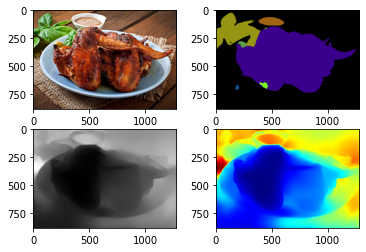

In [ ]:
display_out()